In [14]:
import json
import re

import pandas as pd
import numpy as np
from tqdm import tqdm

import cfbd
from cfbd.rest import ApiException

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open("../config.json") as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)["CFBD_API_KEY"]
    )

In [80]:
YEARS = range(1930, 2025)

In [81]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [82]:
# Load games data
all_games = []
with cfbd.ApiClient(configuration) as api_client:
    api_instance = cfbd.GamesApi(api_client)
    for year in tqdm(YEARS, desc="Loading games data"):
        games = api_instance.get_games(year=year)
        df_games = pd.DataFrame([game.to_dict() for game in games])
        df_games.columns = convert_to_snake_case(df_games.columns)
        game_cols = ['id','season','week','season_type','completed','neutral_site',
                    'home_id','home_team','home_points',
                    'away_id','away_team','away_points']
        df_games = df_games[game_cols]
        df_games['season_type'] = df_games['season_type'].apply(lambda x: x.value)
        all_games.append(df_games)

df_games = pd.concat(all_games, ignore_index=True).query("completed == True").reset_index(drop=True)
df_games.head()

Loading games data: 100%|██████████| 95/95 [00:50<00:00,  1.87it/s]


,id,season,week,season_type,completed,neutral_site,home_id,home_team,home_points,away_id,away_team,away_points
0,16829,1930,1,regular,True,False,147,Montana State,44.0,1000702,Centerville (Butte),0.0
1,16830,1930,1,regular,True,False,2628,TCU,40.0,2837,East Texas A&M,0.0
2,16831,1930,1,regular,True,False,2483,Oregon,20.0,1000650,Pacific (Oregon),0.0
3,16832,1930,2,regular,True,False,2184,Duquesne,0.0,277,West Virginia,7.0
4,16841,1930,2,regular,True,False,2553,Sewanee,25.0,55,Jacksonville State,0.0


In [83]:
df_games.isna().sum()

id              0
season          0
week            0
season_type     0
completed       0
neutral_site    0
home_id         0
home_team       0
home_points     0
away_id         0
away_team       0
away_points     0
dtype: int64

In [85]:
# Load team data
all_teams = []
with cfbd.ApiClient(configuration) as api_client:
    api_instance = cfbd.TeamsApi(api_client)
    for year in tqdm(YEARS, desc="Loading team data"):    
        teams = api_instance.get_teams(year=year)
        df = pd.DataFrame([team.to_dict() for team in teams])
        df.columns = convert_to_snake_case(df.columns)
        df.insert(0, 'season', year)
        all_teams.append(df)

df_teams = pd.concat(all_teams, ignore_index=True)
df_teams.head()

Loading team data:   0%|          | 0/95 [00:00<?, ?it/s]


ApiException: (429)
Reason: Too Many Requests
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 23 Feb 2025 22:14:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '42', 'Connection': 'keep-alive', 'Content-Security-Policy': "default-src 'self';base-uri 'self';font-src 'self' https: data:;form-action 'self';frame-ancestors 'self';img-src 'self' data:;object-src 'none';script-src 'self';script-src-attr 'none';style-src 'self' https: 'unsafe-inline';upgrade-insecure-requests", 'Cross-Origin-Opener-Policy': 'same-origin', 'Cross-Origin-Resource-Policy': 'same-origin', 'Origin-Agent-Cluster': '?1', 'Referrer-Policy': 'no-referrer', 'Strict-Transport-Security': 'max-age=15552000; includeSubDomains', 'X-Content-Type-Options': 'nosniff', 'X-DNS-Prefetch-Control': 'off', 'X-Download-Options': 'noopen', 'X-Frame-Options': 'SAMEORIGIN', 'X-Permitted-Cross-Domain-Policies': 'none', 'X-XSS-Protection': '0', 'Access-Control-Allow-Origin': '*', 'X-CallLimit-Remaining': '0', 'ETag': 'W/"2a-StelzfS0jIRCg7niwxsUXo9zp3Y"', 'cf-cache-status': 'DYNAMIC', 'Report-To': '{"endpoints":[{"url":"https:\\/\\/a.nel.cloudflare.com\\/report\\/v4?s=CwasVx8tqri%2B6BVMFJHeZi7f5Cl%2F5urY5pNK5gDeZ%2FJJN1OhTvI5OY3MF%2FKxzV2JeGs41XgWdno4rP%2FPlJ5wG8wagXzfNJl6F9lbPME3A%2BC5HiFCPEIU6gRxeJRJVHo03H9Q3YGmBnBc2t6t%2Bj2CraHz8fU6sd5aAOrzBQxe"}],"group":"cf-nel","max_age":604800}', 'NEL': '{"success_fraction":0,"report_to":"cf-nel","max_age":604800}', 'Server': 'cloudflare', 'CF-RAY': '916a91c67aafe27f-ORD', 'alt-svc': 'h3=":443"; ma=86400', 'server-timing': 'cfL4;desc="?proto=TCP&rtt=21688&min_rtt=21540&rtt_var=8374&sent=5&recv=6&lost=0&retrans=0&sent_bytes=2875&recv_bytes=876&delivery_rate=177930&cwnd=252&unsent_bytes=0&cid=30c93de52be6afd0&ts=116&x=0"'})
HTTP response body: {"message":"Monthly call quota exceeded."}


In [20]:
# Merge in team data
team_cols = ['season','id','abbreviation','conference','classification','color','alternate_color','logos']

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'home_' + c for c in team_cols}),
    left_on=['season','home_id'],
    right_on=['home_season','home_id'], 
).drop(columns=['home_season'])

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'away_' + c for c in team_cols}),
    left_on=['season','away_id'],
    right_on=['away_season','away_id'],
).drop(columns=['away_season'])

In [21]:
id_cols = ['id','season','week','season_type','completed','neutral_site']
team_cols = [c for c in df_games.columns if c not in id_cols]
df_games = df_games[id_cols + sorted(team_cols)]
df_games.head()

,id,season,week,season_type,completed,neutral_site,away_abbreviation,away_alternate_color,away_classification,away_color,away_conference,away_id,away_logos,away_points,away_team,home_abbreviation,home_alternate_color,home_classification,home_color,home_conference,home_id,home_logos,home_points,home_team
0,49660,1980,1,regular,True,False,ARK,#ffffff,fbs,#a41f35,Southwest,8,[http://a.espncdn.com/i/teamlogos/ncaa/500/8.p...,17.0,Arkansas,TEX,#ffffff,fbs,#c15d26,Southwest,251,[http://a.espncdn.com/i/teamlogos/ncaa/500/251...,23.0,Texas
1,49661,1980,2,regular,True,False,NIU,#cc0000,fbs,#F1122C,Mid-American,2459,[http://a.espncdn.com/i/teamlogos/ncaa/500/245...,16.0,Northern Illinois,LBS,#null,fbs,#null,PCAA,1000006,None,9.0,Long Beach State
2,49684,1980,2,regular,True,False,MSST,#c1c6c8,fbs,#5d1725,SEC,344,[http://a.espncdn.com/i/teamlogos/ncaa/500/344...,34.0,Mississippi State,MEM,#8e908f,fbs,#004991,FBS Independents,235,[http://a.espncdn.com/i/teamlogos/ncaa/500/235...,7.0,Memphis
3,49682,1980,2,regular,True,False,MCN,#null,fbs,#00529C,Southland,2377,[http://a.espncdn.com/i/teamlogos/ncaa/500/237...,20.0,McNeese,WES,#null,fbs,#null,Missouri Valley,2704,[http://a.espncdn.com/i/teamlogos/ncaa/500/270...,17.0,West Texas A&M
4,49681,1980,2,regular,True,False,VILL,#13b5ea,fbs,#00205b,FBS Independents,222,[http://a.espncdn.com/i/teamlogos/ncaa/500/222...,3.0,Villanova,MD,#ffcd00,fbs,#D5002B,ACC,120,[http://a.espncdn.com/i/teamlogos/ncaa/500/120...,7.0,Maryland


In [22]:
df_games.isna().sum()

id                        0
season                    0
week                      0
season_type               0
completed                 0
neutral_site              0
away_abbreviation       255
away_alternate_color      0
away_classification       0
away_color                0
away_conference           0
away_id                   0
away_logos              753
away_points               0
away_team                 0
home_abbreviation       160
home_alternate_color      0
home_classification       0
home_color                0
home_conference           0
home_id                   0
home_logos              565
home_points               0
home_team                 0
dtype: int64

In [23]:
df = df_games[['season','week','home_id','home_team','home_classification','home_points',
                'away_id','away_team','away_classification','away_points']]

df.head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points
0,1980,1,251,Texas,fbs,23.0,8,Arkansas,fbs,17.0
1,1980,2,1000006,Long Beach State,fbs,9.0,2459,Northern Illinois,fbs,16.0
2,1980,2,235,Memphis,fbs,7.0,344,Mississippi State,fbs,34.0
3,1980,2,2704,West Texas A&M,fbs,17.0,2377,McNeese,fbs,20.0
4,1980,2,120,Maryland,fbs,7.0,222,Villanova,fbs,3.0


In [24]:
df.loc[:,'home_result'] = np.select(
    [df['home_points'] > df['away_points'], df['home_points'] < df['away_points']],
    [1, 0],
    default=0.5
)

df.loc[:,'away_result'] = 1 - df.loc[:,'home_result']

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_49603/1380002410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'home_result'] = np.select(
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_49603/1380002410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'away_result'] = 1 - df.loc[:,'home_result']


In [25]:
HFA = 30
K = 200
DIVISOR = 400

# Initialize dictionaries to cache the latest ELO ratings for each team
home_elo_cache = {}
away_elo_cache = {}

elo_initial = {
    'fbs': 1500.0,
    'fcs': 1300.0,
    'ii': 1000.0,
    'iii': 700.0
}

df = df.copy()
df['home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
df['home_elo_post'] = df['home_elo']
df['away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])
df['away_elo_post'] = df['away_elo']

for season in tqdm(df.season.unique()):
    df_season = df.query("season == @season")
    for week in sorted(df_season.week.unique()):
        df_week = df_season.query("week == @week").copy()
        
        # Update the ELO ratings from the cache
        df_week['home_elo'] = df_week['home_id'].map(home_elo_cache).fillna(df_week['home_elo'])
        df_week['away_elo'] = df_week['away_id'].map(away_elo_cache).fillna(df_week['away_elo'])
        
        df_week['home_elo_post'] = (
            df_week['home_elo'] +
            K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2 # Margin of victory adjustment
            * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
        )
        df_week['away_elo_post'] = (
            df_week['away_elo'] +
            K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2 # Margin of victory adjustment
            * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
        )
        
        # Update the main dataframe with the new ELO ratings
        df.loc[df_week.index, 'home_elo'] = df_week['home_elo'].astype(float)
        df.loc[df_week.index, 'away_elo'] = df_week['away_elo'].astype(float)
        df.loc[df_week.index, 'home_elo_post'] = df_week['home_elo_post'].astype(float)
        df.loc[df_week.index, 'away_elo_post'] = df_week['away_elo_post'].astype(float)
        
        # Update the ELO ratings for the next week in the cache
        home_elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
        away_elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

100%|██████████| 45/45 [00:02<00:00, 21.97it/s]


In [57]:
from sklearn.metrics import log_loss
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

# Define the initial Elo rating configurations
elo_initial_options = [
    {'fbs': 1400.0, 'fcs': 1200.0, 'ii': 1000.0, 'iii': 800.0},
    {'fbs': 1500.0, 'fcs': 1300.0, 'ii': 1100.0, 'iii': 900.0},
    {'fbs': 1600.0, 'fcs': 1400.0, 'ii': 1200.0, 'iii': 1000.0}
]

# Instead of passing dictionaries, pass an index (0, 1, 2)
space = [
    Integer(30, 100, name="HFA"),  # Home Field Advantage
    Integer(100, 400, name="K"),  # K-factor (rating sensitivity)
    Integer(300, 800, name="DIVISOR"),  # Probability scaling
    Integer(0, len(elo_initial_options) - 1, name="elo_initial_idx")  # Index for elo_initial_options
]

def evaluate_elo(df, HFA, K, DIVISOR, elo_initial, train_years, test_year):
    """ Train on train_years and evaluate on test_year using given hyperparameters. """

    # Single Elo cache for all teams
    elo_cache = {}

    df = df.copy()
    df['home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
    df['away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])

    # Train on past seasons
    for season in train_years:
        df_season = df.query("season == @season")
        for week in sorted(df_season.week.unique()):
            df_week = df_season.query("week == @week").copy()

            # Update Elo ratings from the unified cache
            df_week['home_elo'] = df_week['home_id'].map(elo_cache).fillna(df_week['home_elo'])
            df_week['away_elo'] = df_week['away_id'].map(elo_cache).fillna(df_week['away_elo'])

            # Calculate post-game Elo ratings
            df_week['home_elo_post'] = (
                df_week['home_elo'] +
                K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2
                * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
            )
            df_week['away_elo_post'] = (
                df_week['away_elo'] +
                K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2
                * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
            )

            # Update single Elo cache with both teams' post-game ratings
            elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
            elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

    # Evaluate on test season
    df_test = df.query("season == @test_year").copy()
    df_test['home_elo'] = df_test['home_id'].map(elo_cache).fillna(df_test['home_elo'])
    df_test['away_elo'] = df_test['away_id'].map(elo_cache).fillna(df_test['away_elo'])

    # Compute win probability using Elo formula
    df_test['elo_prob_win'] = 1 / (1 + 10 ** ((df_test['away_elo'] - HFA - df_test['home_elo']) / DIVISOR))

    # Adjust tie probability dynamically, preventing sum errors
    df_test['elo_prob_tie'] = 0.08 + 0.1 * np.abs(df_test['elo_prob_win'] - 0.5)

    # Compute loss probability correctly
    df_test['elo_prob_loss'] = 1 - df_test['elo_prob_win'] - df_test['elo_prob_tie']

    # 🚨 Normalize probabilities to ensure they sum exactly to 1
    prob_sum = df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].sum(axis=1)
    df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']] = df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].div(prob_sum, axis=0)

    # Convert outcomes to one-hot encoding for log loss
    y_true = np.zeros((len(df_test), 3))
    y_true[np.arange(len(df_test)), df_test['home_result'].astype(int)] = 1

    # Compute Multiclass Log Loss
    log_loss_score = log_loss(y_true, df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].values)

    return log_loss_score

@use_named_args(space)
def objective(HFA, K, DIVISOR, elo_initial_idx):
    """ Objective function for Bayesian Optimization """
    elo_initial = elo_initial_options[elo_initial_idx]  # Retrieve dictionary from index

    log_loss_scores = []

    for test_year in range(1990, 2025):  # Walk-forward validation
        train_years = list(range(1980, test_year))
        log_loss_score = evaluate_elo(df, HFA, K, DIVISOR, elo_initial, train_years, test_year)
        log_loss_scores.append(log_loss_score)

    return np.mean(log_loss_scores)  # Bayesian Optimization minimizes log loss

# Run Bayesian Optimization
result = gp_minimize(objective, space, n_calls=10, random_state=42, verbose=True)

# Extract best parameters
best_HFA, best_K, best_DIVISOR, best_elo_initial_idx = result.x
best_elo_initial = elo_initial_options[best_elo_initial_idx]  # Convert index back to dictionary

print("\nBest Hyperparameters:")
print(f"HFA: {best_HFA}")
print(f"K: {best_K}")
print(f"DIVISOR: {best_DIVISOR}")
print(f"Initial Elo Values: {best_elo_initial}")
print(f"Best Log Loss: {result.fun:.4f}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 33.6687
Function value obtained: 1.8717
Current minimum: 1.8717
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 34.0179
Function value obtained: 1.8889
Current minimum: 1.8717
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 34.2497
Function value obtained: 2.3026
Current minimum: 1.8717
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 34.1091
Function value obtained: 1.8122
Current minimum: 1.8122
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 36.2696
Function value obtained: 1.8727
Current minimum: 1.8122
Iteration No: 6 started. Evalu

In [67]:
from tqdm import tqdm
import numpy as np

# Elo hyperparameters
HFA = 100
K = 100
DIVISOR = 800

# Single Elo cache to track latest ratings for each team
elo_cache = {}

# Initial Elo ratings based on classification
elo_initial = {
    'fbs': 1500.0,
    'fcs': 1300.0,
    'ii': 1000.0,
    'iii': 800.0
}

df = df.copy()
df['home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
df['away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])

df['home_elo_post'] = df['home_elo']
df['away_elo_post'] = df['away_elo']

# Iterate through seasons and weeks
for season in tqdm(df.season.unique()):
    df_season = df.query("season == @season")
    
    for week in sorted(df_season.week.unique()):
        df_week = df_season.query("week == @week").copy()
        
        # Update Elo ratings from the cache
        df_week['home_elo'] = df_week['home_id'].map(elo_cache).fillna(df_week['home_elo'])
        df_week['away_elo'] = df_week['away_id'].map(elo_cache).fillna(df_week['away_elo'])

        # Compute post-game Elo ratings
        df_week['home_elo_post'] = (
            df_week['home_elo'] +
            K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2  # Margin of victory adjustment
            * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
        )
        df_week['away_elo_post'] = (
            df_week['away_elo'] +
            K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2  # Margin of victory adjustment
            * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
        )

        # Update main dataframe with new Elo ratings
        df.loc[df_week.index, 'home_elo'] = df_week['home_elo'].astype(float)
        df.loc[df_week.index, 'away_elo'] = df_week['away_elo'].astype(float)
        df.loc[df_week.index, 'home_elo_post'] = df_week['home_elo_post'].astype(float)
        df.loc[df_week.index, 'away_elo_post'] = df_week['away_elo_post'].astype(float)

        # Update Elo cache for future games
        elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
        elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

100%|██████████| 45/45 [00:02<00:00, 19.20it/s]


In [68]:
df.query("season == 2024").sort_values('away_elo_post', ascending=False).head(20)

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points,home_result,away_result,home_elo,home_elo_post,away_elo,away_elo_post,home_elo_off,away_elo_off,home_elo_def,away_elo_def,home_elo_off_post,away_elo_off_post,home_elo_def_post,away_elo_def_post
49521,2024,3,275,Wisconsin,fbs,10.0,333,Alabama,fbs,42.0,0.0,1.0,2113.256406,2102.788582,3170.003025,3180.470848,1400.0,1400.0,1400.0,1400.0,1329.671743,1574.558932,1480.017183,1653.023928
52751,2024,1,130,Michigan,fbs,19.0,333,Alabama,fbs,13.0,1.0,0.0,3088.057685,3138.959807,3220.281536,3169.379415,1400.0,1400.0,1400.0,1400.0,1555.372011,1572.600642,1706.533022,1630.884691
50580,2024,6,238,Vanderbilt,fbs,40.0,333,Alabama,fbs,35.0,1.0,0.0,1408.572264,1497.511977,3218.449240,3129.509527,1400.0,1400.0,1400.0,1400.0,1516.767841,1566.635240,1426.842489,1504.638776
51215,2024,8,251,Texas,fbs,15.0,61,Georgia,fbs,30.0,0.0,1.0,2859.224686,2799.501774,3056.002234,3115.725146,1400.0,1400.0,1400.0,1400.0,1499.203453,1553.631280,1618.104308,1586.201755
52121,2024,11,99,LSU,fbs,13.0,333,Alabama,fbs,42.0,0.0,1.0,2586.504514,2543.414276,3061.961290,3105.051528,1400.0,1400.0,1400.0,1400.0,1499.863004,1559.389179,1413.073187,1550.092289
49758,2024,3,96,Kentucky,fbs,12.0,61,Georgia,fbs,13.0,0.0,1.0,2140.187611,2137.392602,3085.703187,3088.498197,1400.0,1400.0,1400.0,1400.0,1348.656314,1410.109086,1462.866730,1673.666885
52151,2024,12,77,Northwestern,fbs,7.0,194,Ohio State,fbs,31.0,0.0,1.0,1751.211458,1746.695958,3082.899024,3087.414524,1400.0,1400.0,1400.0,1400.0,1313.484905,1540.249945,1485.793490,1668.034129
51557,2024,10,213,Penn State,fbs,13.0,194,Ohio State,fbs,20.0,0.0,1.0,2699.997380,2665.709303,3046.389332,3080.677410,1400.0,1400.0,1400.0,1400.0,1476.013996,1544.389705,1628.350212,1654.247176
52697,2024,15,251,Texas,fbs,19.0,61,Georgia,fbs,22.0,0.0,1.0,2874.829750,2843.189642,3035.478396,3067.118504,1400.0,1400.0,1400.0,1400.0,1416.385055,1608.719300,1682.620349,1501.251148
50322,2024,5,333,Alabama,fbs,41.0,61,Georgia,fbs,34.0,1.0,0.0,3180.470848,3218.449240,3088.498197,3050.519805,1400.0,1400.0,1400.0,1400.0,1649.498188,1478.659220,1584.473795,1598.727629


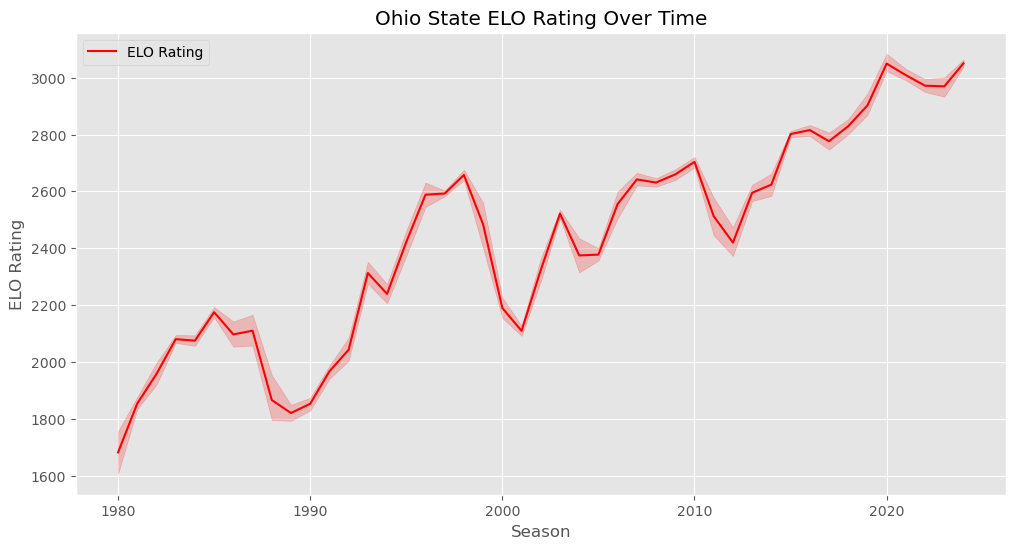

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

team = "Ohio State"

df_wisconsin = df.query("home_team == @team | away_team == @team").copy()
df_wisconsin.loc[:, 'elo'] = df_wisconsin['home_elo'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo'])
df_wisconsin.loc[:, 'elo_post'] = df_wisconsin['home_elo_post'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo_post'])
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_wisconsin, x='season', y='elo_post', label='ELO Rating', color='red')
plt.title(f"{team} ELO Rating Over Time")
plt.xlabel("Season")
plt.ylabel("ELO Rating")
plt.legend()

plt.show()

In [34]:
28 * 10 ** ((1500 - 1400) / 1000)

35.24991153023669

In [38]:
1500 + 10 * np.log(28+1) * (28 - 35) / 28

1491.5817604250337

In [52]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Elo parameters
K = 30  # Update sensitivity factor
DIVISOR = 1000  # Elo divisor for probability calculations

# Single Elo cache for both offensive and defensive ratings
elo_cache_off = {}
elo_cache_def = {}

# Initialize Elo ratings
elo_initial = {
    'fbs': 1400.0,  
    'fcs': 1200.0,
    'ii': 1000.0,
    'iii': 800.0
}

df = df.copy()
df['home_elo_off'] = df['home_classification'].apply(lambda x: elo_initial[x])
df['away_elo_off'] = df['away_classification'].apply(lambda x: elo_initial[x])
df['home_elo_def'] = df['home_classification'].apply(lambda x: elo_initial[x])
df['away_elo_def'] = df['away_classification'].apply(lambda x: elo_initial[x])

df['home_elo_off_post'] = df['home_elo_off']
df['away_elo_off_post'] = df['away_elo_off']
df['home_elo_def_post'] = df['home_elo_def']
df['away_elo_def_post'] = df['away_elo_def']

# Process each season and week
for season in tqdm(df.season.unique()):
    df_season = df.query("season == @season")
    
    for week in sorted(df_season.week.unique()):
        df_week = df_season.query("week == @week").copy()

        # Update Elo ratings from cache
        df_week['home_elo_off'] = df_week['home_id'].map(elo_cache_off).fillna(df_week['home_elo_off'])
        df_week['away_elo_off'] = df_week['away_id'].map(elo_cache_off).fillna(df_week['away_elo_off'])
        df_week['home_elo_def'] = df_week['home_id'].map(elo_cache_def).fillna(df_week['home_elo_def'])
        df_week['away_elo_def'] = df_week['away_id'].map(elo_cache_def).fillna(df_week['away_elo_def'])

        # Compute expected points scored
        df_week['exp_home_points'] = 28 * 10 ** ((df_week['home_elo_off'] - df_week['away_elo_def']) / DIVISOR)
        df_week['exp_away_points'] = 28 * 10 ** ((df_week['away_elo_off'] - df_week['home_elo_def']) / DIVISOR)

        # Update Offensive Elo Ratings
        df_week['home_elo_off_post'] = df_week['home_elo_off'] + K * np.log(df_week['home_points'] + 1) * (df_week['home_points'] - df_week['exp_home_points']) / 28
        df_week['away_elo_off_post'] = df_week['away_elo_off'] + K * np.log(df_week['away_points'] + 1) * (df_week['away_points'] - df_week['exp_away_points']) / 28

        # Update Defensive Elo Ratings
        df_week['home_elo_def_post'] = df_week['home_elo_def'] - K * np.log(df_week['away_points'] + 1) * (df_week['away_points'] - df_week['exp_away_points']) / 28
        df_week['away_elo_def_post'] = df_week['away_elo_def'] - K * np.log(df_week['home_points'] + 1) * (df_week['home_points'] - df_week['exp_home_points']) / 28

        # Update DataFrame with new Elo values
        df.loc[df_week.index, 'home_elo_off_post'] = df_week['home_elo_off_post']
        df.loc[df_week.index, 'away_elo_off_post'] = df_week['away_elo_off_post']
        df.loc[df_week.index, 'home_elo_def_post'] = df_week['home_elo_def_post']
        df.loc[df_week.index, 'away_elo_def_post'] = df_week['away_elo_def_post']

        # Update Elo cache for next games
        elo_cache_off.update(df_week.set_index('home_id')['home_elo_off_post'].to_dict())
        elo_cache_off.update(df_week.set_index('away_id')['away_elo_off_post'].to_dict())
        elo_cache_def.update(df_week.set_index('home_id')['home_elo_def_post'].to_dict())
        elo_cache_def.update(df_week.set_index('away_id')['away_elo_def_post'].to_dict())


100%|██████████| 45/45 [00:03<00:00, 14.04it/s]


In [53]:
df.head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points,home_result,away_result,home_elo,home_elo_post,away_elo,away_elo_post,home_elo_off,away_elo_off,home_elo_def,away_elo_def,home_elo_off_post,away_elo_off_post,home_elo_def_post,away_elo_def_post
0,1980,1,251,Texas,fbs,23.0,8,Arkansas,fbs,17.0,1.0,0.0,1500.0,1588.915155,1500.000000,1411.084845,1400.0,1400.0,1400.0,1400.0,1382.974712,1365.934904,1434.065096,1417.025288
1,1980,2,1000006,Long Beach State,fbs,9.0,2459,Northern Illinois,fbs,16.0,0.0,1.0,1500.0,1387.072498,1500.000000,1612.927502,1400.0,1400.0,1400.0,1400.0,1353.125946,1363.572971,1436.427029,1446.874054
2,1980,2,235,Memphis,fbs,7.0,344,Mississippi State,fbs,34.0,0.0,1.0,1500.0,1264.127623,1376.260112,1612.132489,1400.0,1400.0,1400.0,1400.0,1351.591706,1396.837221,1369.097683,1437.268429
3,1980,2,2704,West Texas A&M,fbs,17.0,2377,McNeese,fbs,20.0,0.0,1.0,1500.0,1414.963472,1449.800723,1534.837251,1400.0,1400.0,1400.0,1400.0,1372.911253,1341.438867,1417.940380,1463.515776
4,1980,2,120,Maryland,fbs,7.0,222,Villanova,fbs,3.0,1.0,0.0,1500.0,1573.540611,1500.000000,1426.459389,1400.0,1400.0,1400.0,1400.0,1330.754749,1360.212077,1412.911531,1443.149345


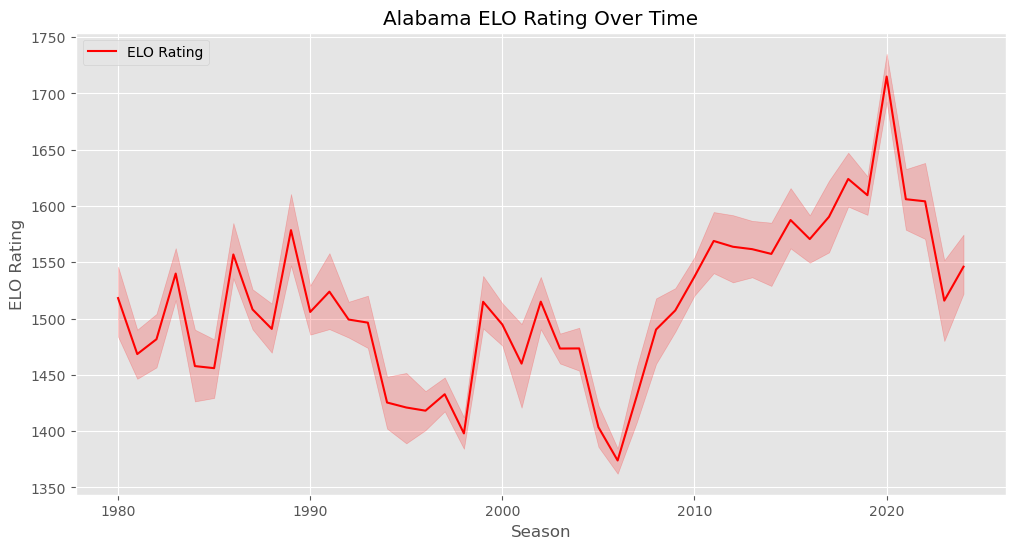

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

team = "Alabama"

df_wisconsin = df.query("home_team == @team | away_team == @team").copy()
df_wisconsin.loc[:, 'elo'] = df_wisconsin['home_elo'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo'])
df_wisconsin.loc[:, 'elo_post'] = df_wisconsin['home_elo_off_post'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo_off_post'])
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_wisconsin, x='season', y='elo_post', label='ELO Rating', color='red')
plt.title(f"{team} ELO Rating Over Time")
plt.xlabel("Season")
plt.ylabel("ELO Rating")
plt.legend()

plt.show()

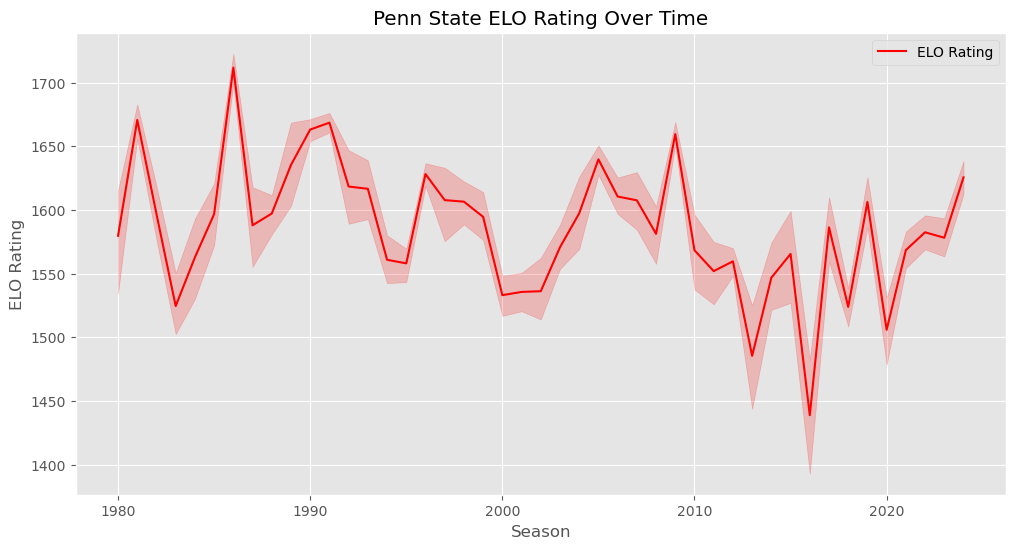

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

team = "Penn State"

df_wisconsin = df.query("home_team == @team | away_team == @team").copy()
df_wisconsin.loc[:, 'elo'] = df_wisconsin['home_elo'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo'])
df_wisconsin.loc[:, 'elo_post'] = df_wisconsin['home_elo_def_post'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo_def_post'])
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_wisconsin, x='season', y='elo_post', label='ELO Rating', color='red')
plt.title(f"{team} ELO Rating Over Time")
plt.xlabel("Season")
plt.ylabel("ELO Rating")
plt.legend()

plt.show()